# Fake News detection and analysis

**Attias** Ben Sebastian, **Bongiovanni** Enrica, **Bustaffa** Marco, **Lombardi** Mattia, **Stropeni** Arianna, **Tiso** Elia

# 1. Preprocessing

In [ ]:
#setup
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize

import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
from timeit import default_timer as timer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


NOTE: upload in your Drive the folder "NLP" that we provided, then run the following cell.

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')
path = 'drive/MyDrive/NLP/'

Mounted at /content/drive/


### Dataset loading and cleaning

NOTE: the dataset provided along with the code is the final one, already including both fake and real news, so it is not possible to run this part again.

In [ ]:
dataset_FAKE = pd.read_csv(path + 'DataSet_Misinfo_FAKE.csv')
dataset_TRUE = pd.read_csv(path + 'DataSet_Misinfo_TRUE.csv')

In [ ]:
from sklearn.utils import shuffle

#add labels to each one of the dataset
dataset_TRUE["label"] = 1
dataset_FAKE["label"] = 0

final_df = pd.concat([dataset_TRUE, dataset_FAKE])

#shuffle the final df so that labels 0 and 1 are randomly ordered
final_df = shuffle(final_df).reset_index(drop=True)

#drop first column, which is unnecessary
final_df = final_df.drop(columns=['Unnamed: 0'])

#check whether there are missing values and eventually drop them
final_df.isna().sum()
final_df.dropna(how = 'any', inplace=True)

### Language detection

Since a minority of the articles are in a language different from English, we created a method to detect and then remove them from the dataset we will use in the following analysis.

NOTE: we suggest not to run this part, since it takes far too long and the dataset provided has already been cleaned of other languages.

In [ ]:
!pip install langdetect
from langdetect import detect_langs

In [ ]:
def detect_language(text, min_prob_threshold=0.97):
    try:
        lang_info = detect_langs(text)
        for info in lang_info:
            if info.lang == 'en' and info.prob >= min_prob_threshold:
                return True, 'en'
        #return the first detected non-English language
        return False, lang_info[0].lang
    except:
        return False, 'unknown'

In [ ]:
import os

#lists to collect English and non-English rows
english_rows = []
non_english_rows = []
eng_count = 0
non_eng_count = 0

if os.path.exists(path+"DatasetEng.csv"):
    print(f"Dataframe Present")
    #if the file doesn't exists, it saves the dataset
    df = pd.read_csv(path+"DatasetEng.csv")
    print("English samples: \t", df.shape[0])
    print(f"Dataframe Uploaded")
else:
    print(f"Dataframe Absent")
    #classify each text
    start = timer()
    start1 = timer()
    for index, row in final_df.iterrows():
        if index%2500 == 0 and index:
          end = timer()
          diff1 = end - start1
          diff = end - start
          print(f"{index}: {eng_count}, {non_eng_count}\nPartial:{diff1:.0f}s \t Total:{diff:.0f}s")
          start1 = timer()
        is_eng, lang = detect_language(row['text'])
        if is_eng:
            english_rows.append(row)
            eng_count += 1
        else:
            non_english_row = row.copy()
            non_english_row['detected_language'] = lang
            non_english_rows.append(non_english_row)
            non_eng_count += 1

        #create the two dataframes for english and non english text
        english_df = pd.DataFrame(english_rows)
        non_english_df = pd.DataFrame(non_english_rows)

        print("Text samples: \t\t", final_df.shape[0])
        print("English samples: \t", english_df.shape[0])
        print("Non-english samples: \t", non_english_df.shape[0])
        print(f"Ratio: \t\t\t {(english_df.shape[0]*100/final_df.shape[0]):.2f}%")

        #save english dataset
        english_df.to_csv(path+"DatasetEng.csv", index = False)
        print(f"Dataframe Downloaded")
        df = english_df

### General preprocessing

This is the general preprocessing function that has been applied to the dataset.

In [ ]:
#reload english df to avoid rerunning the previous cell
df  = pd.read_csv(path + 'Final_dataset.csv')

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    #convert text to lowercase
    text = text.lower()
    #tokenize the text to separate into words
    words = word_tokenize(text)
    #remove stopwords
    words = [word for word in words if word not in stopwords]
    #lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    #rejoin the tokenized words into a string to feed into some of the embedding techinques (e.g. TF-IDF)
    processed_text = ' '.join(words)

    return processed_text

In [ ]:
df_H = df.head(5)
df_H["processed"] = df_H["text"].apply(preprocess_text)

<ipython-input-9-8a4c14d3af30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H["processed"] = df_H["text"].apply(preprocess_text)


In [ ]:
df_H

,text,label,processed,topic,keywords
0,Looks like that slippery little scut Marco Rub...,0,look like slippery little scut marco rubio dod...,Fiscal policy,"['Marco Rubio', 'scut Marco', 'Rubio dodged', ..."
1,The U.S. House of Representatives voted unanim...,1,u.s. house representative voted unanimously we...,President Obama,"['Representatives voted', 'Justice Department'..."
2,"During the campaign, Trump had threatened to i...",1,"campaign , trump threatened impose large tarif...",President Trump,"['United States', 'Trump', 'campaign', 'jobs']"
3,"Jenice Armstrong, Philly, October 26, 2016 \nT...",0,"jenice armstrong , philly , october 26 , 2016 ...",Asian politics,"['Jenice Armstrong', 'Temple', 'October', 'sni..."
4,The Texas Bar Association is stepping up to th...,0,texas bar association stepping plate nail ken ...,Law,"['Supreme Court', 'Ken Paxton', 'Texas Bar', '..."


NOTE: we suggest you do not run the following cells, as they are required to preprocess and save the data and they have been run only once since they are very time consuming. An example of the function applied to the first five rows of the dataset is provided above.

In [ ]:
#apply the function to the dataset
df["processed"] = df["text"].apply(preprocess_text)

In [ ]:
#save the preprocessed dataset so that the preprocessing isn't applied every time the code is run
df.to_csv(path+"Eng_df_preprocessed.csv", index = False)

**NOTE: load the dataset in the cell below, that is the one attached to the code.**

In [ ]:
#reload preprocessed dataset
final_eng_df = pd.read_csv(path+"Final_dataset.csv")

# 2. Models for text classification

## SVM Models

This part was realized by **Attias B.S.** and **Tiso E.**

**NOTE: if you have memory constraints, it is recommended that you run each section as stand-alone and then you clear the runtime. Here we provide the original dataset. Please rerun the following cells every time you disconnect the runtime.**

This part also requires an additional dataset, that will be loaded in the cells below.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')
path = 'drive/MyDrive/NLP/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
final_eng_df = pd.read_csv(path+"Final_dataset.csv")

### Useful functions

We decided to extract some useful features from the dataset so that the SVM model has more information to be trained on. Following are all the functions that have been defined and then applied to the dataset.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from gensim import corpora, models

def avg_sentence_length(sentences):
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    if sentence_lengths:
        return sum(sentence_lengths) / len(sentence_lengths)
    return 0

#numerical words/total words
def ratio_numerical_words(text):
    words = word_tokenize(text)
    if words:
        numerical_words = [word for word in words if word.isdigit()]
        return len(numerical_words) / len(words)
    return 0

#seed words/sentence length
def ratio_seed_words(sentences, seed_words):
    seed_word_count = sum([word in seed_words for sentence in sentences for word in word_tokenize(sentence)])
    total_words = sum([len(word_tokenize(sentence)) for sentence in sentences])
    if total_words:
        return seed_word_count / total_words
    return 0

#grammar errors/text length (deactivated later on because time consuming)
def ratio_grammar_errors(text, act=0):
    if act:
      blob = TextBlob(text)
      errors = sum([len(sentence.correct().words) != len(sentence.words) for sentence in blob.sentences])
      total_words = len(blob.words)
      if total_words:
          return errors / total_words
      return 0
    return 0

#LDA
def preprocess_for_lda(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and word.isalpha()]
    return words

def num_topics(text, lda_model, dictionary):
    words = preprocess_for_lda(text)
    bow = dictionary.doc2bow(words)
    topics = lda_model.get_document_topics(bow)
    return len(topics)

#agglomeration
def extract_features(text, seed_words, lda_model, dictionary):
    sentences = preprocess_text(text)
    stop0 = timer()
    elem1 = avg_sentence_length(sentences)
    stop1 = timer()
    delta1 = stop1 - stop0
    elem2 = num_topics(text,  lda_model, dictionary)
    stop2 = timer()
    delta2 = stop2 - stop1
    elem3 = ratio_numerical_words(text)
    stop3 = timer()
    delta3 = stop3 - stop2
    elem4 = ratio_seed_words(sentences, seed_words)
    stop4 = timer()
    delta4 = stop4 - stop3
    elem5 = ratio_grammar_errors(text)
    stop5 = timer()
    delta5 = stop5 - stop4

    features = {
        'avg_sentence_length': elem1,
        'num_topics': elem2,
        'ratio_numerical_words': elem3,
        'ratio_seed_words': elem4,
        'ratio_grammar_errors': elem5
    }

    delta_list = [delta1, delta2, delta3, delta4, delta5]
    return features, delta_list

#seed words using TF-IDF
def extract_seed_words(df, n=10):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df['text'])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = X.toarray().sum(axis=0)

    #get top N words as seed words
    top_indices = tfidf_scores.argsort()[-n:]
    seed_words = [feature_names[i] for i in top_indices]
    return seed_words

### Creation of the new datasets

To reduce the computational complexity of the following operations and comply with Colab limits, the dataset has been divided into 10 chunks.

In [ ]:
n = 10
chunk_size = len(final_eng_df) // n
print(chunk_size)
chunk_list = [final_eng_df[i*chunk_size:(i+1)*chunk_size] for i in range(n-1)]
remainder = final_eng_df[(n-1)*chunk_size:]
chunk_list.append(remainder)
origin_df = final_eng_df
RUN = False

7781


NOTE: the following operations are still very time consuming, so we suggest not to try and run it. We only did it once as well and created a dataset that will specifically be used for SVM and that is composed of all the features that have been added.

In [ ]:

if RUN:
  ii = 1
  ijk = 0
  for chu in chunk_list:
    df = chu
    if ii == n:
      print(f"CHUNK {ii} ({(ii-1)*chunk_size} - {len(final_eng_df)})")
    else:
      print(f"CHUNK {ii} ({(ii-1)*chunk_size} - {(ii)*chunk_size})")
    seed_words = extract_seed_words(df)
    print("Seed Words found: ", ", ".join(seed_words[:min(len(seed_words), 3)]), "...")

    #LDA
    texts = [preprocess_for_lda(text) for text in df['text']]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

    start = timer()
    default_list = [extract_features(text, seed_words, lda_model, dictionary)
                    for text in df['text']]
    feature_list = [x[0] for x in default_list]
    time_list = [x[1] for x in default_list]
    time_list1 = zip(*time_list)
    sums_time = [sum(column) for column in time_list1]
    feat_keys = list(feature_list[0].keys())
    i = 0
    for y in sums_time:
      print(f"{feat_keys[i]} time: {y:.2f}s")
      i += 1
    end = timer()
    delta = end - start
    print(f"Total time needed: {delta:.2f}s")

    if ijk == 0:
      if os.path.exists(path+"DatasetFeatures.csv"):
          print(f"Dataframe Present")
          os.remove(path+"DatasetFeatures.csv")
          print(f"Dataframe Erased")
      else:
          print(f"Dataframe Absent")
      df_features = pd.DataFrame(feature_list)
      df_features.to_csv(path+"DatasetFeatures.csv", index = False)
      print(f"Dataframe Downloaded")
      ijk = 1
    else:
      print(f"Dataframe Present")
      df_pre = pd.read_csv(path + "DatasetFeatures.csv")
      df_new = pd.DataFrame(feature_list)
      df_features = pd.concat([df_pre, df_new], axis=0)
      os.remove(path+"DatasetFeatures.csv")
      print(f"Dataframe Erased")
      df_features.to_csv(path+"DatasetFeatures.csv", index = False)
      print(f"Dataframe Uploaded")

    ii += 1
    print("\nShape: ", df_features.shape, "\n")
    #print(df_features.tail(5))

    df_features.reset_index(drop=True, inplace=True)
    df_features_T = pd.concat([final_eng_df['label'], df_features], axis=1)
    os.remove(path+"DatasetFeatures.csv")
    df_features_T.to_csv(path+"DatasetFeatures.csv", index = False)
  RUN = False

**NOTE: run the following cell so that you have all the required datasets to run the SVM.**

In [ ]:
df = final_eng_df
df_features = pd.read_csv(path+"DatasetFeatures.csv")
#drop column ratio_grammar_error, which is empty as it was too time consuming to compute them
df_features.drop(columns = ["ratio_grammar_errors"], inplace = True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


#TF-IDF and BOW Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words="english")
bow_vectorizer = CountVectorizer(max_features=20, stop_words="english")

#fit and transform the text data
tfidf_features = tfidf_vectorizer.fit_transform(df['processed'])
bow_features = bow_vectorizer.fit_transform(df['processed'])

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

#define a function to apply SVM to a dataframe
def apply_svm(df, label_column='label'):
    y = df[label_column]
    X = df.drop(columns=[label_column])
    print('Y shape', y.shape, "X shape", X.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report, y_test, y_pred

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

#define a function to compute and display the confusion matrix
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["1","0"],
        cmap=plt.cm.Blues)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    prec_score = tp / (tp + fp)
    rec_score = tp / (tp + fn)
    f1_score = tp / (tp+((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset")
    print("Precision: \t"+ str(prec_score.round(2)))
    print("Recall: \t"+ str(rec_score.round(2)))
    print("F1 score: \t"+ str(f1_score.round(2)))

### SVM on Feature Dataset

In [ ]:
print(f"Dataset: Features")
start = timer()
accuracy, report, y_test, y_pred = apply_svm(df_features)
end = timer()
delta = end- start
print(f"Time needed: {delta:.0f}s")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Dataset: Features
Y shape (77819,) X shape (77819, 4)
Time needed: 617s
Accuracy: 0.6054356206630687
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67      8646
           1       0.57      0.46      0.51      6918

    accuracy                           0.61     15564
   macro avg       0.60      0.59      0.59     15564
weighted avg       0.60      0.61      0.60     15564



Precision: 	0.57
Recall: 	0.46
F1 score: 	0.51


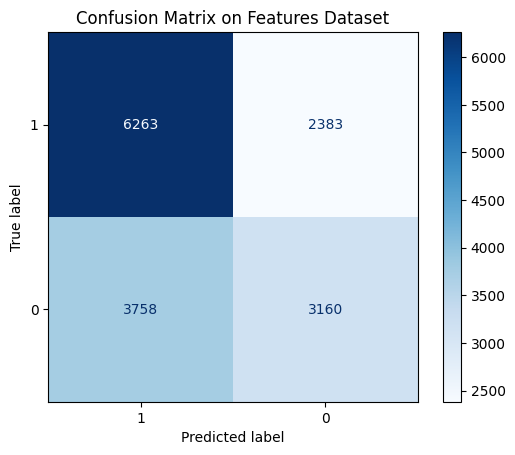

In [ ]:
displayConfusionMatrix(y_test, y_pred, "Features")

### SVM with TF-IDF embedding

In [ ]:
print(f"Dataset: TF-IDF")
start = timer()

y = final_eng_df["label"]
X = tfidf_features
print('Y shape', y.shape, "X shape", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
end = timer()
delta = end- start

print(f"Time needed: {delta:.0f}s")
print(f"Accuracy: {accuracy}")
print(f"Classification report: {report}")

Dataset: TF-IDF
Y shape (77819,) X shape (77819, 500)
Time needed: 917s
Accuracy: 0.8955923927011051
Classification report:               precision    recall  f1-score   support

           0       0.91      0.91      0.91      8646
           1       0.88      0.88      0.88      6918

    accuracy                           0.90     15564
   macro avg       0.89      0.89      0.89     15564
weighted avg       0.90      0.90      0.90     15564



Precision: 	0.88
Recall: 	0.88
F1 score: 	0.88


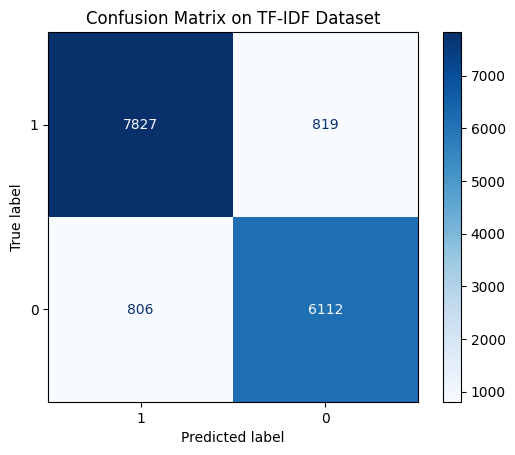

In [ ]:
displayConfusionMatrix(y_test, y_pred, "TF-IDF")

### SVM with BOW embedding

Note: as you can also see from the running time, the SVM with BOW embedding takes far more time than the other two; you can run it if you want but be aware that it would take around 40 minutes.

In [ ]:
print(f"Dataset: BOW")
start = timer()

y = final_eng_df["label"]
X = bow_features
print('Y shape', y.shape, "X shape", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
end = timer()
delta = end- start

print(f"Time needed: {delta:.0f}s")
print(f"Accuracy: {accuracy}")
print(f"Classification report: {report}")

Dataset: BOW
Y shape (77819,) X shape (77819, 20)
Time needed: 2463s
Accuracy: 0.7579671035723464
Classification report:               precision    recall  f1-score   support

           0       0.74      0.88      0.80      8646
           1       0.80      0.61      0.69      6918

    accuracy                           0.76     15564
   macro avg       0.77      0.74      0.75     15564
weighted avg       0.76      0.76      0.75     15564



Precision: 	0.8
Recall: 	0.61
F1 score: 	0.69


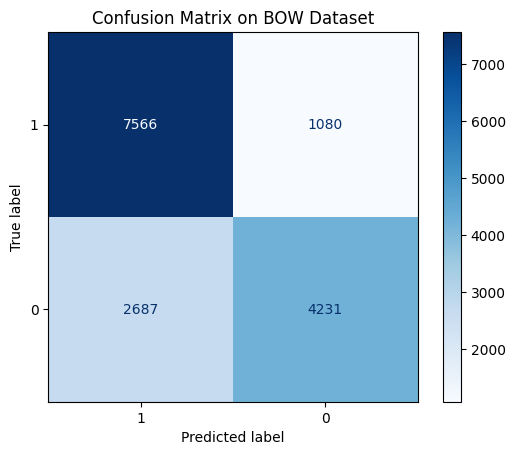

In [ ]:
displayConfusionMatrix(y_test, y_pred, "BOW")

## Neural networks

**NOTE: if you have memory constraints, it is recommended that you run each section as stand-alone and then you clear the runtime. Here we provide the original dataset. Please rerun the following cell every time you disconnect the runtime.**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')
path = 'drive/MyDrive/NLP/'

Mounted at /content/drive/


In [ ]:
final_eng_df = pd.read_csv(path+"Final_dataset.csv")

In [ ]:
data = final_eng_df['processed'].values
labels = final_eng_df['label'].values

### Simple NN architecture

This part was realized by **Lombardi M.**

In [ ]:
#split the data into training, test and validation set
X_train_val, X_test, y_train_val, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42)

In [ ]:
#vectorize using a TF-IDF embedding
num_words = 10000
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=num_words,
 standardize="lower_and_strip_punctuation",
 split="whitespace",
 output_mode='tf_idf',
 pad_to_max_tokens=True)

vectorize_layer.adapt(X_train)

In [ ]:
X_train = vectorize_layer(X_train)
X_val = vectorize_layer(X_val)
X_test  = vectorize_layer(X_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160356 (626.39 KB)
Trainable params: 160356 (626.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


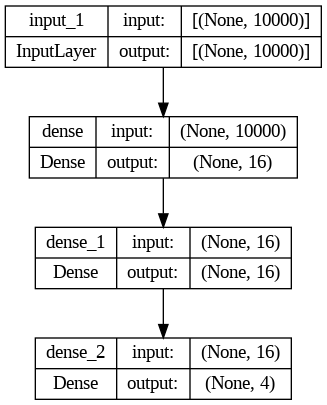

In [ ]:
#define the model
model = Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(1e-3)),
    keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(1e-3)),
    keras.layers.Dense(4, activation="softmax", kernel_regularizer=tf.keras.regularizers.l1(1e-3))
])
model.summary()
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
#fit the model
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
1557/1557 [==============================] - 7s 4ms/step - loss: 0.6593 - accuracy: 0.9327 - val_loss: 0.5411 - val_accuracy: 0.9485
Epoch 2/20
1557/1557 [==============================] - 5s 3ms/step - loss: 0.5135 - accuracy: 0.9520 - val_loss: 0.4685 - val_accuracy: 0.9576
Epoch 3/20
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4699 - accuracy: 0.9578 - val_loss: 0.4650 - val_accuracy: 0.9509
Epoch 4/20
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4557 - accuracy: 0.9580 - val_loss: 0.4693 - val_accuracy: 0.9562
Epoch 5/20
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4492 - accuracy: 0.9592 - val_loss: 0.4831 - val_accuracy: 0.9540
Epoch 6/20
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4325 - accuracy: 0.9621 - val_loss: 0.4481 - val_accuracy: 0.9616
Epoch 7/20
1557/1557 [==============================] - 5s 3ms/step - loss: 0.4191 - accuracy: 0.9638 - val_loss: 0.4071 - val_accuracy:

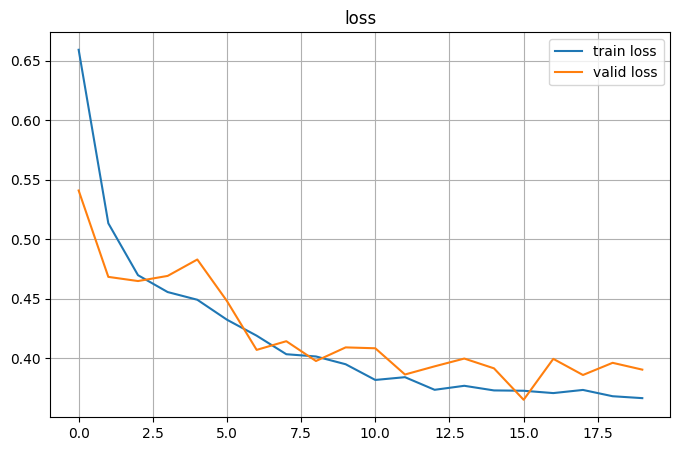

In [ ]:
#define a function that plots learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.epoch,history.history['loss'], label='train loss')
    plt.plot(history.epoch,history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.grid(True)
    plt.show()
plot_learning_curves(history)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

487/487 [==============================] - 1s 2ms/step - loss: 0.4060 - accuracy: 0.9570
Test Loss: 0.406007319688797
Test Accuracy: 0.956951916217804


487/487 [==============================] - 1s 2ms/step


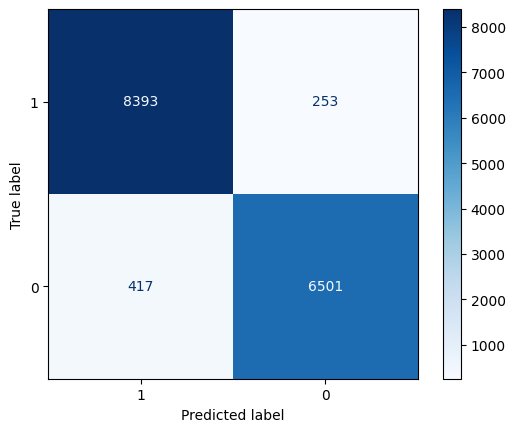

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")


#create confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=["1","0"],
        cmap=plt.cm.Blues)

### CNN architecture

This part was realized by **Bustaffa M.**

In [ ]:
#we split again into training, test and validation, to use another embedding technique
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.80)

To prepare text data for the learning model, we transform each news into a sequence, since the preprocessing function had returned a string. Every word in the news is mapped to an integer index and thus the sentence turns into a sequence of numbers. The approach is different with respect to the one adopted in the previous case.

In [ ]:
#Keras tokenizer
tokenizer = Tokenizer(oov_token='<UNK>')

#fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)
tokenizer.word_index['<PAD>'] = 0

#transform text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

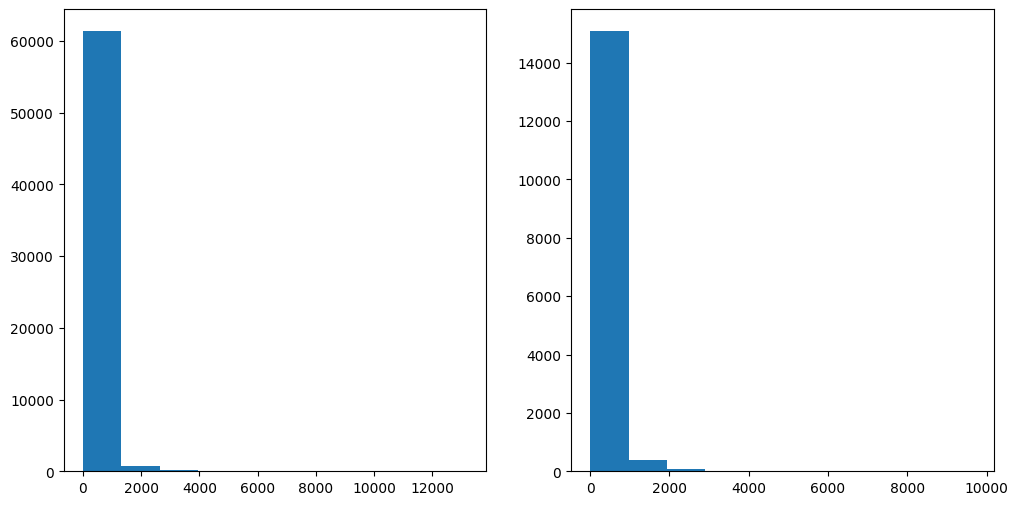

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#check the length of the sequences
train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

Not all news are of same length. To handle this difference in length of news, we define a maximum length. For news which are smaller than this length, we pad them with zeros which longer ones are truncated.

In [ ]:
MAX_SEQUENCE_LENGTH = 2000
VOCAB_SIZE = len(tokenizer.word_index)

#pad dataset to a maximum news length in words
X_train_vectorized = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_vectorized = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
EMBED_SIZE = 30
EPOCHS=25
BATCH_SIZE=128

# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=8, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 30)          5235990   
                                                                 
 conv1d (Conv1D)             (None, 2000, 8)           968       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1000, 8)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8000)              0         
                                                                 
 dense_3 (Dense)             (None, 32)                256032    
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                      

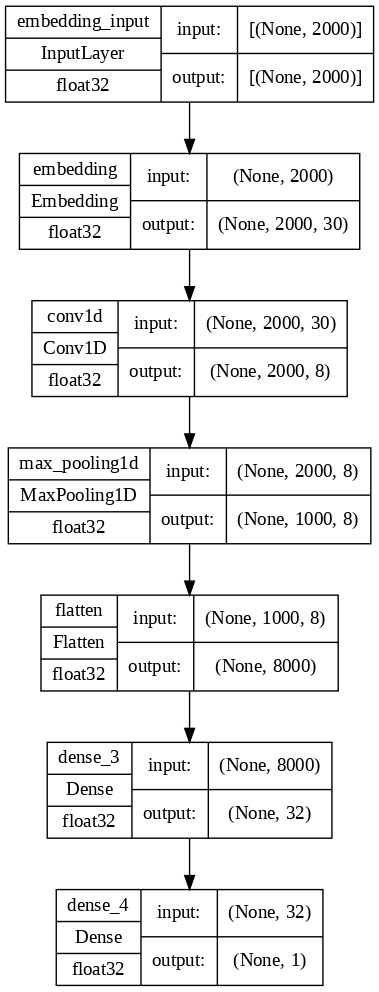

In [ ]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

Epoch 1/25
390/390 [==============================] - 58s 139ms/step - loss: 0.6808 - accuracy: 0.5697 - val_loss: 0.6735 - val_accuracy: 0.5952
Epoch 2/25
390/390 [==============================] - 44s 113ms/step - loss: 0.6658 - accuracy: 0.6034 - val_loss: 0.6591 - val_accuracy: 0.6073
Epoch 3/25
390/390 [==============================] - 38s 97ms/step - loss: 0.6477 - accuracy: 0.6205 - val_loss: 0.6362 - val_accuracy: 0.6245
Epoch 4/25
390/390 [==============================] - 32s 82ms/step - loss: 0.6163 - accuracy: 0.6621 - val_loss: 0.5970 - val_accuracy: 0.6854
Epoch 5/25
390/390 [==============================] - 27s 70ms/step - loss: 0.5688 - accuracy: 0.7223 - val_loss: 0.5432 - val_accuracy: 0.7495
Epoch 6/25
390/390 [==============================] - 22s 56ms/step - loss: 0.5091 - accuracy: 0.7839 - val_loss: 0.4818 - val_accuracy: 0.8090
Epoch 7/25
390/390 [==============================] - 21s 55ms/step - loss: 0.4459 - accuracy: 0.8363 - val_loss: 0.4211 - val_accurac

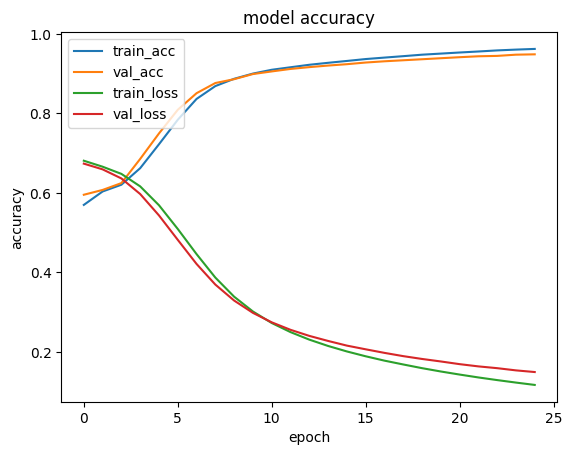

In [ ]:
results = model.fit(X_train_vectorized, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE)

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='valid loss')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc', "train_loss", "val_loss"], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(X_test_vectorized, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

487/487 [==============================] - 1s 2ms/step - loss: 0.1499 - accuracy: 0.9474
Accuracy: 94.74%


487/487 [==============================] - 1s 1ms/step


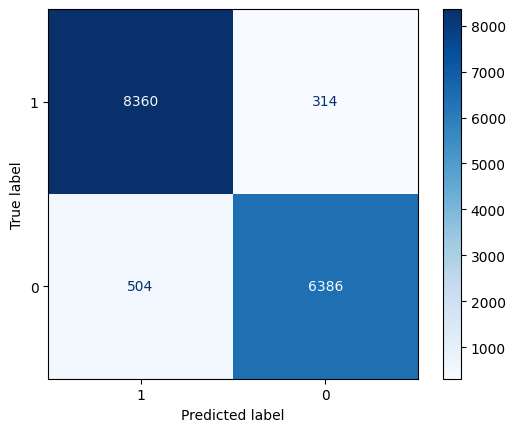

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(X_test_vectorized)
y_pred = (y_pred_probs > 0.5).astype("int32")


#create confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=["1","0"],
        cmap=plt.cm.Blues)

## Recurrent Neural Networks

This part was realized by **Bongiovanni E.** and **Stropeni A.**

**NOTE: if you have memory constraints, it is recommended that you run each section as stand-alone and then you clear the runtime. Here we provide the original dataset. Please rerun the following cell every time you disconnect the runtime.**

**This part specifically, run as a stand-alone, requires around 16GB RAM, so if your constraints are lower than that we suggest you avoid running it altogether. You can still see the results of each cell.**

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')
path = 'drive/MyDrive/NLP/'

Mounted at /content/drive/


In [ ]:
final_eng_df = pd.read_csv(path+"Final_dataset.csv")

In [ ]:
import gensim
from gensim.models import Word2Vec

#split the string into tokens
list_of_words = [sentence.split(" ") for sentence in final_eng_df["processed"]]

#split data into training, validation and test set
from sklearn.model_selection import train_test_split
labels = final_eng_df["label"]

X_train_val, X_test, y_train_val, y_test = train_test_split(list_of_words, labels, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42)

In [ ]:
#embed through Word2Vec
model_train = Word2Vec(sentences=X_train, vector_size=16, window=5, min_count=5, workers=4)

In [ ]:
def sentence_to_vectors(sentence, model):
    return [model.wv[word] for word in sentence if word in model.wv]

#convert sentences to vectors
vectorized_train = [sentence_to_vectors(sentence, model_train) for sentence in X_train]
vectorized_val = [sentence_to_vectors(sentence, model_train) for sentence in X_val]
vectorized_test = [sentence_to_vectors(sentence, model_train) for sentence in X_test]

In [ ]:
#check how many articles have less than 1000 words
less_than_1000 = sum(len(article) < 1000 for article in vectorized_train)/len(vectorized_train)
print(less_than_1000)

0.9555658180065858


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#pad sequences so that all have the same length
padded_test = pad_sequences(vectorized_test, maxlen=1000, dtype='float32', padding='post', truncating='post')
padded_val = pad_sequences(vectorized_val, maxlen=1000, dtype='float32', padding='post', truncating='post')
padded_train = pad_sequences(vectorized_train, maxlen=1000, dtype='float32', padding='post', truncating='post')

### LSTM Architecture

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

#convert labels into array
y_train = np.array(y_train)
y_val = np.array(y_val)

model = Sequential()
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

#compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/12
1557/1557 [==============================] - 61s 37ms/step - loss: 0.6098 - accuracy: 0.6389 - val_loss: 0.6309 - val_accuracy: 0.5665
Epoch 2/12
1557/1557 [==============================] - 55s 35ms/step - loss: 0.4757 - accuracy: 0.7470 - val_loss: 0.2031 - val_accuracy: 0.9257
Epoch 3/12
1557/1557 [==============================] - 55s 35ms/step - loss: 0.1631 - accuracy: 0.9397 - val_loss: 0.1362 - val_accuracy: 0.9490
Epoch 4/12
1557/1557 [==============================] - 55s 35ms/step - loss: 0.1044 - accuracy: 0.9633 - val_loss: 0.1026 - val_accuracy: 0.9636
Epoch 5/12
1557/1557 [==============================] - 54s 35ms/step - loss: 0.0764 - accuracy: 0.9742 - val_loss: 0.0723 - val_accuracy: 0.9745
Epoch 6/12
1557/1557 [==============================] - 54s 35ms/step - loss: 0.0602 - accuracy: 0.9792 - val_loss: 0.0669 - val_accuracy: 0.9776
Epoch 7/12
1557/1557 [==============================] - 54s 35ms/step - loss: 0.0490 - accuracy: 0.9831 - val_loss: 0.0756 -

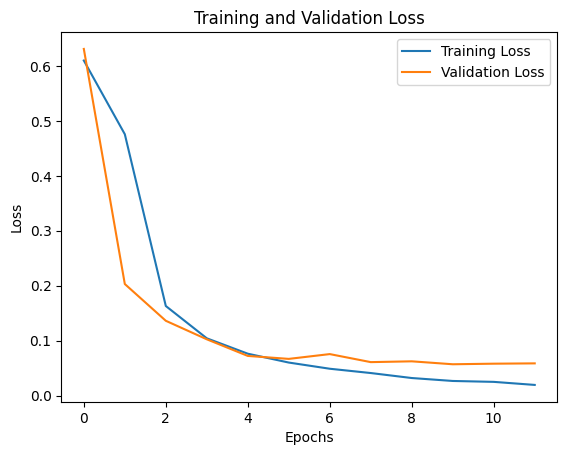

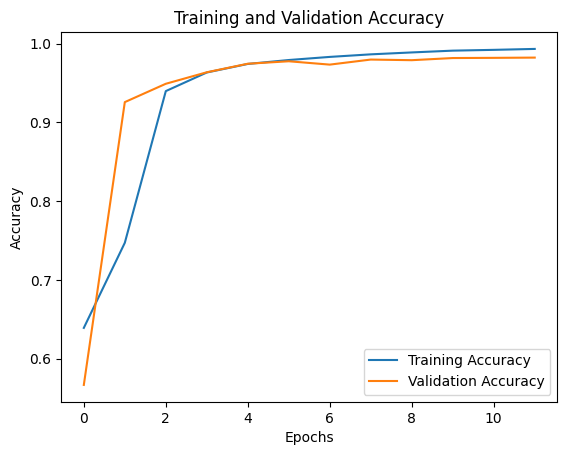

In [ ]:
history = model.fit(padded_train, y_train, epochs=12, batch_size=32, validation_data=(padded_val, y_val))

#plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(padded_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

487/487 [==============================] - 9s 15ms/step - loss: 0.0599 - accuracy: 0.9834
Test Loss: 0.059940990060567856
Test Accuracy: 0.9834232926368713


487/487 [==============================] - 7s 13ms/step


Text(0.5, 1.0, 'Confusion Matrix with LSTM model')

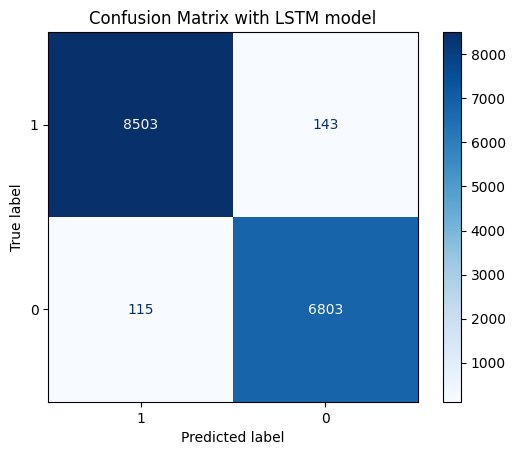

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(padded_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

#create confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=["1","0"],
        cmap=plt.cm.Blues)

disp.ax_.set_title("Confusion Matrix with LSTM model")

In [ ]:
#print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8646
           1       0.98      0.98      0.98      6918

    accuracy                           0.98     15564
   macro avg       0.98      0.98      0.98     15564
weighted avg       0.98      0.98      0.98     15564



### GRU Architecture

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

model = Sequential()
model.add(GRU(64))
model.add(Dense(1, activation='sigmoid'))

#compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/12
1557/1557 [==============================] - 50s 31ms/step - loss: 0.6094 - accuracy: 0.6613 - val_loss: 0.4699 - val_accuracy: 0.7942
Epoch 2/12
1557/1557 [==============================] - 46s 30ms/step - loss: 0.2507 - accuracy: 0.9052 - val_loss: 0.1213 - val_accuracy: 0.9548
Epoch 3/12
1557/1557 [==============================] - 47s 30ms/step - loss: 0.0982 - accuracy: 0.9650 - val_loss: 0.0856 - val_accuracy: 0.9670
Epoch 4/12
1557/1557 [==============================] - 46s 30ms/step - loss: 0.0710 - accuracy: 0.9753 - val_loss: 0.0628 - val_accuracy: 0.9785
Epoch 5/12
1557/1557 [==============================] - 51s 32ms/step - loss: 0.0560 - accuracy: 0.9809 - val_loss: 0.0589 - val_accuracy: 0.9798
Epoch 6/12
1557/1557 [==============================] - 46s 29ms/step - loss: 0.0449 - accuracy: 0.9849 - val_loss: 0.0599 - val_accuracy: 0.9789
Epoch 7/12
1557/1557 [==============================] - 45s 29ms/step - loss: 0.0366 - accuracy: 0.9873 - val_loss: 0.0555 -

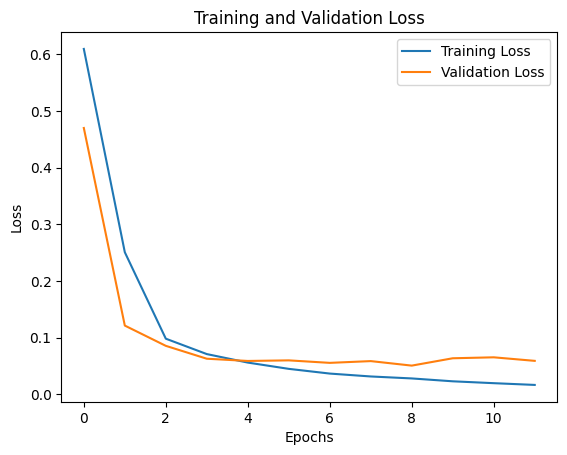

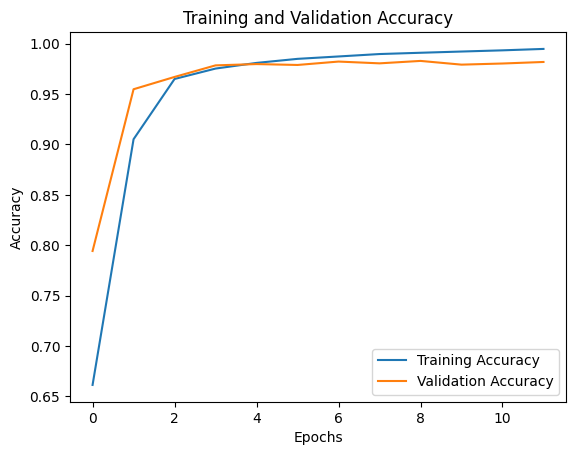

In [ ]:
history = model.fit(padded_train, y_train, epochs=12, batch_size=32, validation_data=(padded_val, y_val))

#plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(padded_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

487/487 [==============================] - 7s 13ms/step - loss: 0.0610 - accuracy: 0.9828
Test Loss: 0.061029013246297836
Test Accuracy: 0.9828450083732605


487/487 [==============================] - 6s 13ms/step


Text(0.5, 1.0, 'Confusion Matrix with GRU model')

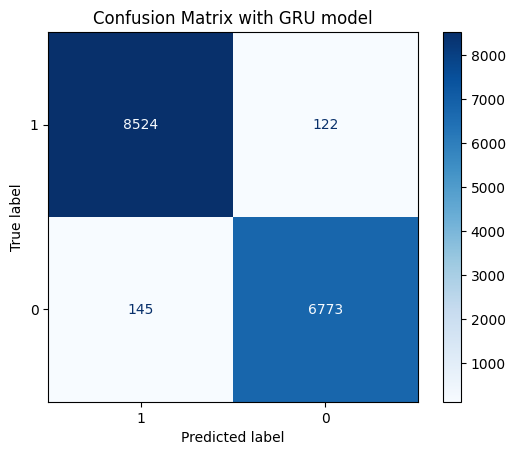

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(padded_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=["1","0"],
        cmap=plt.cm.Blues)

disp.ax_.set_title("Confusion Matrix with GRU model")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8646
           1       0.98      0.98      0.98      6918

    accuracy                           0.98     15564
   macro avg       0.98      0.98      0.98     15564
weighted avg       0.98      0.98      0.98     15564



# 3. Keyword extraction and clustering

**NOTE: if you have memory constraints, it is recommended that you run each section as stand-alone and then you clear the runtime. Here we provide the original dataset. Please rerun the following cell every time you disconnect the runtime.**

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')
path = 'drive/MyDrive/NLP/'

Mounted at /content/drive/


In [ ]:
final_eng_df = pd.read_csv(path+"Final_dataset.csv")

## Keywords extraction

This part was realized by **Bongiovanni E.**, **Lombardi M.** and **Stropeni A.**

In [ ]:
!pip install yake
import yake

#define function for keyword extraction
def keyword_extraction(text):
  language = "en"
  max_ngram_size = 2
  deduplication_threshold = 0.2
  windowsSize = 5
  numOfKeywords = 5
  custom_kw_extractor = yake.KeywordExtractor(windowsSize = windowsSize, lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
  keywords = custom_kw_extractor.extract_keywords(text)
  list_of_keywords = []
  for element in keywords:
    list_of_keywords.append(element[0])
  return list_of_keywords

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
df_H = final_eng_df.head()
df_H["keywords"] = df_H["text"].apply(keyword_extraction)

<ipython-input-5-deeb45c298ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H["keywords"] = df_H["text"].apply(keyword_extraction)


In [ ]:
df_H

,text,label,processed,topic,keywords
0,Looks like that slippery little scut Marco Rub...,0,look like slippery little scut marco rubio dod...,Fiscal policy,"[Marco Rubio, scut Marco, Rubio dodged, Donald..."
1,The U.S. House of Representatives voted unanim...,1,u.s. house representative voted unanimously we...,President Obama,"[Representatives voted, Justice Department, vo..."
2,"During the campaign, Trump had threatened to i...",1,"campaign , trump threatened impose large tarif...",President Trump,"[United States, Trump, campaign, jobs]"
3,"Jenice Armstrong, Philly, October 26, 2016 \nT...",0,"jenice armstrong , philly , october 26 , 2016 ...",Asian politics,"[Jenice Armstrong, Temple, October, snip, Frid..."
4,The Texas Bar Association is stepping up to th...,0,texas bar association stepping plate nail ken ...,Law,"[Supreme Court, Ken Paxton, Texas Bar, nail Ke..."


NOTE: we suggest you don't run the following cell as it is very time consuming. An example is provided above.

In [ ]:
#apply keyword extraction to unprocessed text
final_eng_df["keywords"] = final_eng_df["text"].apply(keyword_extraction)

In [ ]:
#save final dataset with the new column "keywords"
final_df.to_csv(path+"Final_dataset.csv", index = False)

Since during the download as ".csv" the list of keywords was converted into a string, we need to reconvert it into a list to correctly work on it.

In [ ]:
import ast

final_eng_df['keywords'] = final_eng_df['keywords'].apply(ast.literal_eval)

<ipython-input-8-961219a04168>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')


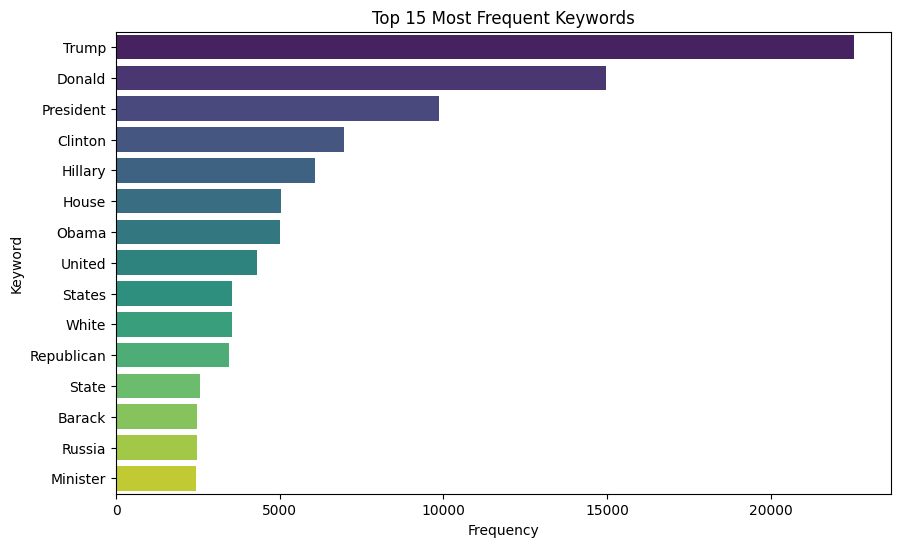

In [ ]:
import seaborn as sns

all_keywords = [word for sublist in final_eng_df['keywords'] for keyword in sublist for word in keyword.split()]

#convert the list back to a pandas Series
all_keywords = pd.Series(all_keywords)

#count the frequency of each keyword
keyword_counts = all_keywords.value_counts()

#visualize the top 15 most frequent keywords
top_n = 15
top_keywords = keyword_counts.head(top_n)

#plot the frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')
plt.title(f'Top {top_n} Most Frequent Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

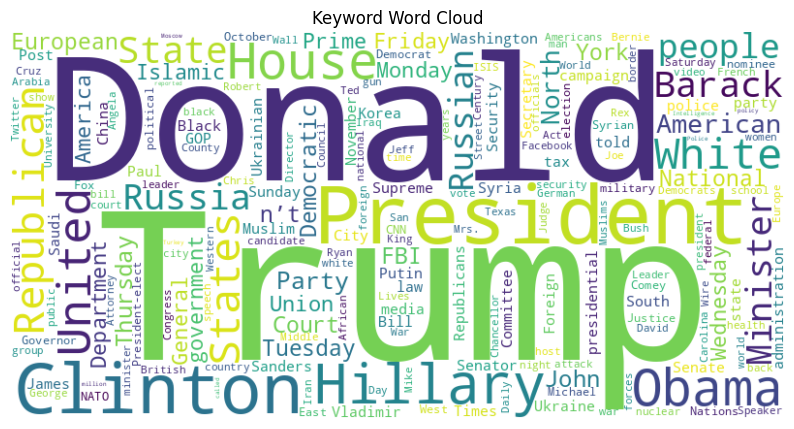

In [ ]:
from wordcloud import WordCloud

#generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

#display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud')
plt.show()

Since the words "Trump" and "Donald" seem to appear disproportionately many times with respect to all the other, we tried generating the same graphs as before but excluding them, to visualize more clearly the most frequent keywords.

<ipython-input-10-fe7ff6dc5b2a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')


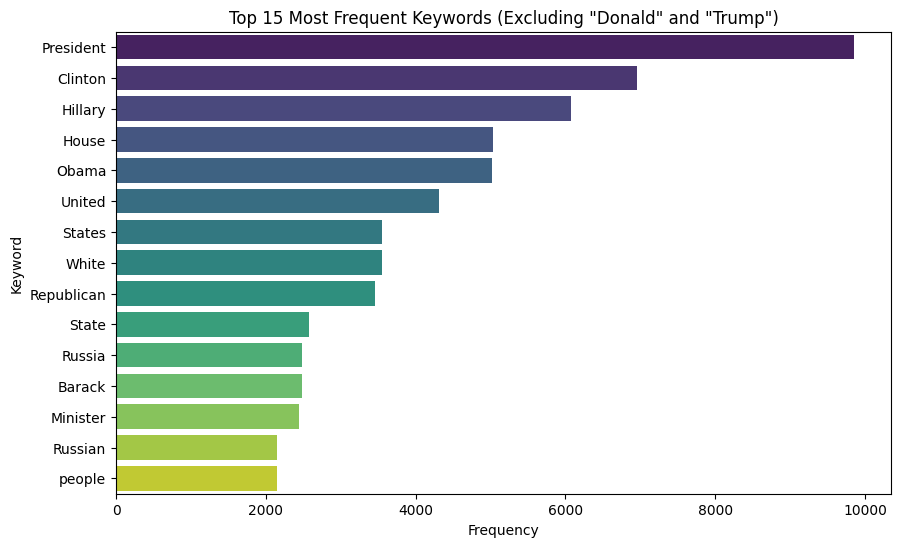

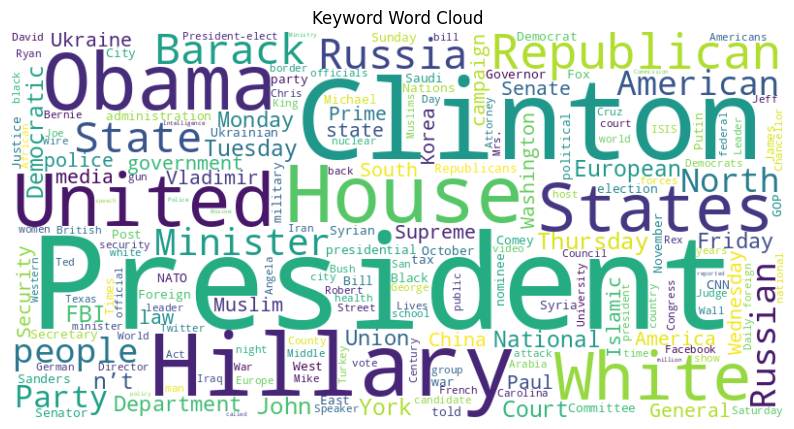

In [ ]:
exclude_words = {'Donald', 'Trump'}
filtered_keywords = [word for word in all_keywords if word not in exclude_words]

filtered_keywords_series = pd.Series(filtered_keywords)

keyword_counts = filtered_keywords_series.value_counts()

#visualize the top 15 most frequent keywords
top_n = 15
top_keywords = keyword_counts.head(top_n)

#plot the frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')
plt.title(f'Top {top_n} Most Frequent Keywords (Excluding "Donald" and "Trump")')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

#generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

#display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud')
plt.show()

## Topic detection

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')
path = 'drive/MyDrive/NLP/'

Mounted at /content/drive/


In [ ]:
final_eng_df = pd.read_csv(path+"Final_dataset.csv")

This part was realized by **Bongiovanni E.** and **Stropeni A.**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorize the processed text by using a TF-IDF embedding, suitable with NMF
vectorizer = TfidfVectorizer(max_features = 10000)
X_tfidf = vectorizer.fit_transform(final_eng_df["processed"])

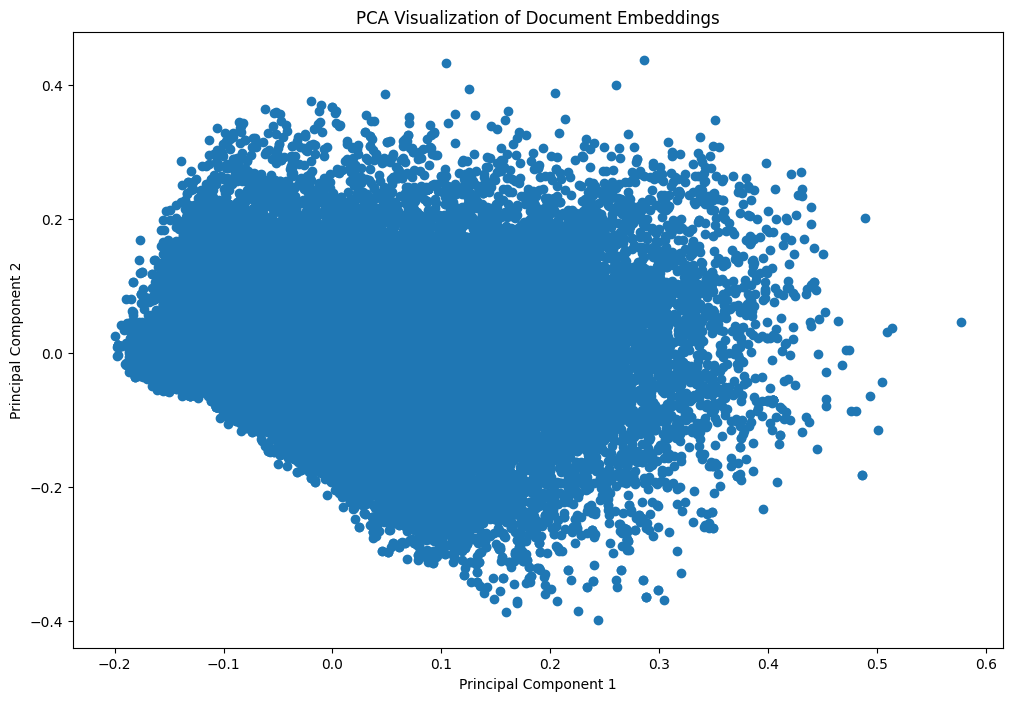

In [ ]:
#visualize the points in a lower dimensional space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#transform TF-IDF vector into dense array
dense_tfidf_matrix = X_tfidf.toarray()

#reduce dimensions with PCA
pca = PCA(n_components=2)
pca_values = pca.fit_transform(dense_tfidf_matrix)

#plot the PCA result
plt.figure(figsize=(12, 8))
plt.scatter(pca_values[:, 0], pca_values[:, 1])
plt.title('PCA Visualization of Document Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

To evaluate the performance of NMF, we defined a function that plot the reconstruction error of the model for a number of clusters that goes from 10 to 40.

In [ ]:
from sklearn.decomposition import NMF

def evaluate_nmf(doc_term_matrix, num_topics_list):
    reconstruction_errors = []
    for num_topics in num_topics_list:
        #fit the NMF model
        nmf = NMF(n_components=num_topics, random_state=42)
        W = nmf.fit_transform(doc_term_matrix)
        H = nmf.components_

        #reconstruction error
        reconstruction_error = nmf.reconstruction_err_
        reconstruction_errors.append(reconstruction_error)

    return reconstruction_errors

NOTE: we suggest you don't run the following cell as it is very time consuming.

In [ ]:
num_topics_list = range(10, 40)
reconstruction_errors = evaluate_nmf(X_tfidf, num_topics_list)
for num_topics, rec_err in zip(num_topics_list, reconstruction_errors):
    print(f"Num Topics: {num_topics}, Reconstruction Error: {rec_err:.2f}")

plt.plot(num_topics_list, reconstruction_errors, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Number of Topics')
plt.xticks(num_topics_list)
plt.grid(True)
plt.show()

The results show that the reconstruction error keeps decreasing as we increase the number of topics, due to the large size of the dataset. However, having that many clusters lacks interpretability, thus after some manual fine tuning we decided to fix the number of topics to 14.

In [ ]:
#fit the final NMF model
num_topics = 14
nmf = NMF(n_components=num_topics, random_state=42)

#fit the NMF model
nmf.fit(X_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=14, random_state=42)

In [ ]:
#define a function to display the topics generated by NMF
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

#display the topics and the top 15 words for each
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(nmf, tf_feature_names, 15)

Topic 0:
trump donald president campaign image said white twitter supporter realdonaldtrump featured rally republican america via
Topic 1:
people one like woman time black life know get right video year say american even
Topic 2:
clinton hillary email campaign foundation sander democratic obama wikileaks mrs podesta state secretary bill server
Topic 3:
russia russian putin moscow nato intelligence vladimir election sanction war syria kremlin foreign crimea military
Topic 4:
republican house senate obama bill president said obamacare democrat white ryan congress senator legislation committee
Topic 5:
mr said ms mrs new york time year company campaign trump one official would _____
Topic 6:
korea north china nuclear korean missile south said pyongyang united sanction state chinese test japan
Topic 7:
fbi comey investigation email director james information department intelligence election official committee server classified letter
Topic 8:
syria said syrian islamic state al military for

After manually inspecting the top words of each cluster, we noticed that Topic 1 and Topic 5 lacked interpretability. Thus, they have been removed and the articles reassigned to the second most probable topic.

To avoid this problem altogether, it would have been possible to extract only names and adjectives from the processed text through POS tagging: however, this was not possible in this case because it became highly time consuming.

In [ ]:
#delete Topic 1 and Topic 5, which are not informative
W = nmf.fit_transform(X_tfidf)
H = nmf.components_

#remove the corresponding columns from the factorization matrices
W_filtered = np.delete(W, [1,5], axis=1)
H_filtered = np.delete(H, [1,5], axis=0)

#assign articles to remaining topics
topic_assignments = np.argmax(W_filtered, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
#manually create topic names
topic_names = [
    "President Trump",
    "Hillary Clinton",
    "Russia",
    "President Obama",
    "Asian politics",
    "FBI investigations",
    "Middle East politics",
    "American elections",
    "European politics",
    "Law",
    "Fiscal policy",
    "Ukrainian War"
]

#create a mapping between topic index and topic names
topic_mapping = {i: name for i, name in enumerate(topic_names)}

#rename the topic assignments
renamed_topic_assignments = [topic_mapping[topic] for topic in topic_assignments]

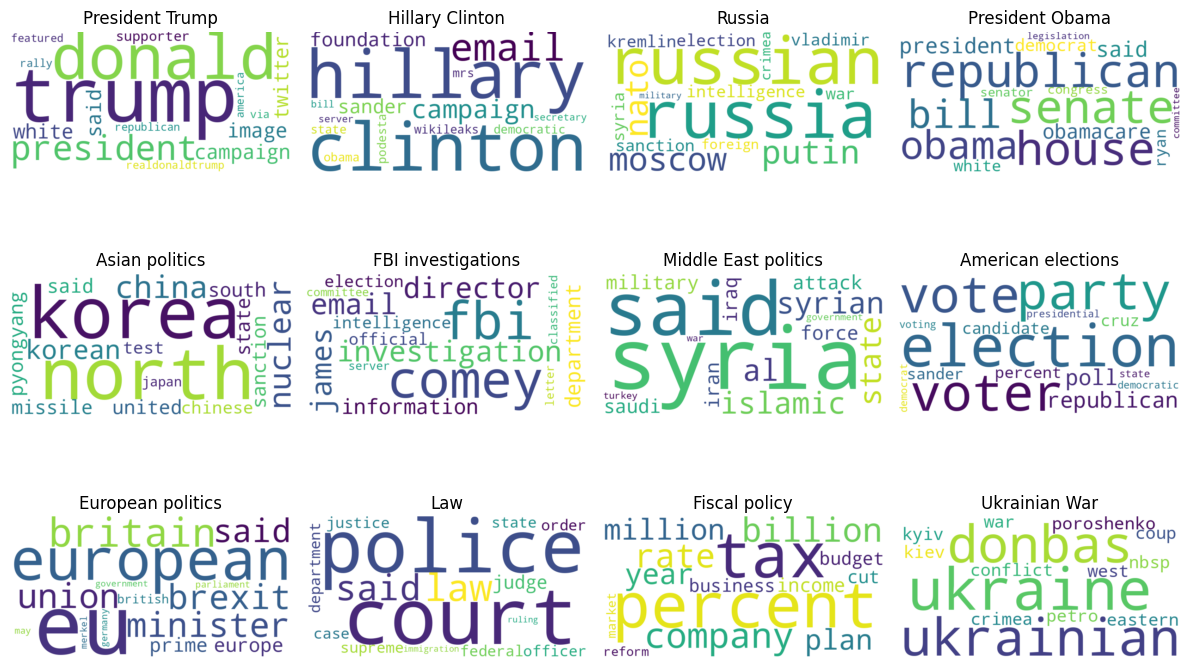

In [ ]:
from wordcloud import WordCloud

num_words = 15

#define top words per topic
top_words_per_topic = []
for topic_idx, topic in enumerate(H_filtered):
    top_words_idx = topic.argsort()[-num_words:][::-1]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
    top_words_per_topic.append(top_words)

#plot word clouds for each topic
plt.figure(figsize=(12, 8))
for i, top_words in enumerate(top_words_per_topic):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))
    topic_name = topic_mapping.get(i, "Unknown")
    plt.subplot(3, 4, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(topic_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

We decided it would be interesting to calculate the ratio between the number of fake news articles assigned to each topic and the overall number of articles in each cluster.

In [ ]:
#count the number of total articles and fake news articles for each topic
total_articles_per_topic = {i: 0 for i in range(H_filtered.shape[0])}
fake_news_counts_per_topic = {i: 0 for i in range(H_filtered.shape[0])}

for topic, fake_news_flag in zip(topic_assignments, final_eng_df["label"]):
    total_articles_per_topic[topic] += 1  # Count total articles for the topic
    if fake_news_flag == 0:  # Check if the news is fake
        fake_news_counts_per_topic[topic] += 1  # Count fake news articles for the topic

#calculate the ratio of fake news articles to total articles for each topic
fake_news_ratio_per_topic = {}
for topic_idx, total_count in total_articles_per_topic.items():
    fake_news_count = fake_news_counts_per_topic[topic_idx]
    fake_news_ratio_per_topic[topic_idx] = fake_news_count / total_count if total_count > 0 else 0

#print the ratio of fake news articles to total articles for each topic
for topic_idx, ratio in fake_news_ratio_per_topic.items():
    print(f"Topic {topic_idx}: {ratio:.2f} ratio of fake news articles")

Topic 0: 0.75 ratio of fake news articles
Topic 1: 0.77 ratio of fake news articles
Topic 2: 0.72 ratio of fake news articles
Topic 3: 0.43 ratio of fake news articles
Topic 4: 0.28 ratio of fake news articles
Topic 5: 0.71 ratio of fake news articles
Topic 6: 0.41 ratio of fake news articles
Topic 7: 0.53 ratio of fake news articles
Topic 8: 0.42 ratio of fake news articles
Topic 9: 0.47 ratio of fake news articles
Topic 10: 0.47 ratio of fake news articles
Topic 11: 0.94 ratio of fake news articles


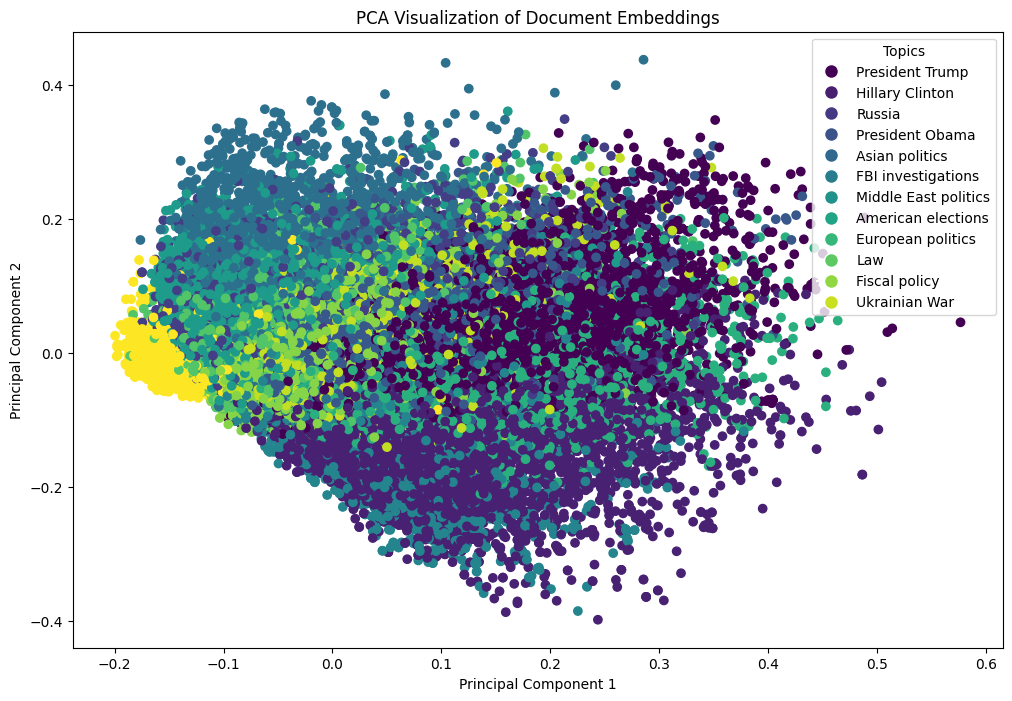

In [ ]:
#show the graph obtained with PCA colouring the different clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_values[:, 0], pca_values[:, 1], c=topic_assignments, cmap='viridis')
plt.title('PCA Visualization of Document Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

#add legend for topics
unique_topics = np.unique(topic_assignments)
legend_labels = [topic_mapping[topic] for topic in unique_topics]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(unique_topics)), markersize=10) for i, topic in enumerate(unique_topics)]
plt.legend(handles, legend_labels, title="Topics")

plt.show()

Note: you don't have to run the following cells, we only ran it once to add the column to the dataset.

In [ ]:
#create a new column for the dataset and save it
final_eng_df["topic"] = renamed_topic_assignments
final_eng_df.to_csv(path+"Final_dataset.csv", index = False)

# 5. Sentiment analysis

This part was realized by **Attias B.S.**, **Bustaffa M.** and **Tiso E.**

**NOTE: if you have memory constraints, it is recommended that you run each section as stand-alone and then you clear the runtime. In this particular section, you don't require the original dataset to run the code, only that it is in the correct folder.**

Note: we suggest you don't run the following two cells as they are computationally expensive and you already have all the datasets required for the following analysis.

In [ ]:
!python /content/drive/MyDrive/NLP/extract_columns.py /content/drive/MyDrive/NLP/Final_dataset.csv /content/drive/MyDrive/NLP/sample_complete.csv text,label

In [ ]:
!python /content/drive/MyDrive/NLP/code/avgEmoValues.py --dataPath /content/drive/MyDrive/NLP/sample_complete.csv --lexPath /content/drive/MyDrive/NLP/code/lexicons/NRC-VAD-Lexicon.csv --lexNames valence dominance arousal --savePath /content/drive/MyDrive/NLP/dataset_sent/

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
df_arousal = pd.read_csv("/content/drive/MyDrive/NLP/dataset_sent/arousal.csv")
df_arousal.head(10)

,text,label,numTokens,numLexTokens,avgLexVal,lexRatio
0,Looks like that slippery little scut Marco Rub...,0,1336,475,0.447025,0.355539
1,The U.S. House of Representatives voted unanim...,1,332,130,0.440146,0.391566
2,"During the campaign, Trump had threatened to i...",1,17,7,0.579857,0.411765
3,"Jenice Armstrong, Philly, October 26, 2016 \nT...",0,347,102,0.445892,0.293948
4,The Texas Bar Association is stepping up to th...,0,340,125,0.502760,0.367647
5,(Want to get this briefing by email? Here’s th...,1,648,215,0.494893,0.331790
6,Donald Trump wasn t the only presidential cand...,0,767,214,0.506575,0.279009
7,Someone isn t happy with the current possibili...,0,417,119,0.434941,0.285372
8,"Immediately after this happened, Charles Kraut...",0,10,2,0.738000,0.200000
9,Mitch McConnell just made a statement on the S...,0,113,37,0.460243,0.327434


In [ ]:
df_dominance = pd.read_csv("/content/drive/MyDrive/NLP/dataset_sent/dominance.csv")
df_dominance.head(10)

,text,label,numTokens,numLexTokens,avgLexVal,lexRatio
0,Looks like that slippery little scut Marco Rub...,0,1336,475,0.553501,0.355539
1,The U.S. House of Representatives voted unanim...,1,332,130,0.615508,0.391566
2,"During the campaign, Trump had threatened to i...",1,17,7,0.650571,0.411765
3,"Jenice Armstrong, Philly, October 26, 2016 \nT...",0,347,102,0.508941,0.293948
4,The Texas Bar Association is stepping up to th...,0,340,125,0.628720,0.367647
5,(Want to get this briefing by email? Here’s th...,1,648,215,0.569884,0.331790
6,Donald Trump wasn t the only presidential cand...,0,767,214,0.628977,0.279009
7,Someone isn t happy with the current possibili...,0,417,119,0.569202,0.285372
8,"Immediately after this happened, Charles Kraut...",0,10,2,0.497500,0.200000
9,Mitch McConnell just made a statement on the S...,0,113,37,0.624622,0.327434


In [ ]:
df_valence = pd.read_csv("/content/drive/MyDrive/NLP/dataset_sent/valence.csv")
df_valence.head(10)

,text,label,numTokens,numLexTokens,avgLexVal,lexRatio
0,Looks like that slippery little scut Marco Rub...,0,1336,475,0.594421,0.355539
1,The U.S. House of Representatives voted unanim...,1,332,130,0.611631,0.391566
2,"During the campaign, Trump had threatened to i...",1,17,7,0.550429,0.411765
3,"Jenice Armstrong, Philly, October 26, 2016 \nT...",0,347,102,0.589392,0.293948
4,The Texas Bar Association is stepping up to th...,0,340,125,0.567648,0.367647
5,(Want to get this briefing by email? Here’s th...,1,648,215,0.571865,0.331790
6,Donald Trump wasn t the only presidential cand...,0,767,214,0.578051,0.279009
7,Someone isn t happy with the current possibili...,0,417,119,0.632252,0.285372
8,"Immediately after this happened, Charles Kraut...",0,10,2,0.291500,0.200000
9,Mitch McConnell just made a statement on the S...,0,113,37,0.561486,0.327434


In [ ]:
text = df_arousal['text']
label = df_arousal['label']
arousal_numTokens = df_arousal['numTokens']
arousal_numLexTokens = df_arousal['numLexTokens']
arousal_avgLexVal = df_arousal['avgLexVal']
arousal_lexRatio = df_arousal['lexRatio']

dominance_numTokens = df_dominance['numTokens']
dominance_numLexTokens = df_dominance['numLexTokens']
dominance_avgLexVal = df_dominance['avgLexVal']
dominance_lexRatio = df_dominance['lexRatio']

valence_numTokens = df_valence['numTokens']
valence_numLexTokens = df_valence['numLexTokens']
valence_avgLexVal = df_valence['avgLexVal']
valence_lexRatio = df_valence['lexRatio']

df_combined = pd.concat([text, label, arousal_numTokens, arousal_numLexTokens, arousal_avgLexVal, arousal_lexRatio,
                         dominance_numTokens, dominance_numLexTokens, dominance_avgLexVal, dominance_lexRatio,
                         valence_numTokens, valence_numLexTokens, valence_avgLexVal, valence_lexRatio], axis=1)

df_combined.columns = ['text', 'label', 'arousal_numTokens', 'arousal_numLexTokens', 'arousal_avgLexVal', 'arousal_lexRatio',
                       'dominance_numTokens', 'dominance_numLexTokens', 'dominance_avgLexVal', 'dominance_lexRatio',
                       'valence_numTokens', 'valence_numLexTokens', 'valence_avgLexVal', 'valence_lexRatio']

output_csv = '/content/drive/MyDrive/NLP/dataset_sent/sentimentAnalysis.csv'
df_combined.to_csv(output_csv, index=False)

df_combined.head(10)

,text,label,arousal_numTokens,arousal_numLexTokens,arousal_avgLexVal,arousal_lexRatio,dominance_numTokens,dominance_numLexTokens,dominance_avgLexVal,dominance_lexRatio,valence_numTokens,valence_numLexTokens,valence_avgLexVal,valence_lexRatio
0,Looks like that slippery little scut Marco Rub...,0,1336,475,0.447025,0.355539,1336,475,0.553501,0.355539,1336,475,0.594421,0.355539
1,The U.S. House of Representatives voted unanim...,1,332,130,0.440146,0.391566,332,130,0.615508,0.391566,332,130,0.611631,0.391566
2,"During the campaign, Trump had threatened to i...",1,17,7,0.579857,0.411765,17,7,0.650571,0.411765,17,7,0.550429,0.411765
3,"Jenice Armstrong, Philly, October 26, 2016 \nT...",0,347,102,0.445892,0.293948,347,102,0.508941,0.293948,347,102,0.589392,0.293948
4,The Texas Bar Association is stepping up to th...,0,340,125,0.502760,0.367647,340,125,0.628720,0.367647,340,125,0.567648,0.367647
5,(Want to get this briefing by email? Here’s th...,1,648,215,0.494893,0.331790,648,215,0.569884,0.331790,648,215,0.571865,0.331790
6,Donald Trump wasn t the only presidential cand...,0,767,214,0.506575,0.279009,767,214,0.628977,0.279009,767,214,0.578051,0.279009
7,Someone isn t happy with the current possibili...,0,417,119,0.434941,0.285372,417,119,0.569202,0.285372,417,119,0.632252,0.285372
8,"Immediately after this happened, Charles Kraut...",0,10,2,0.738000,0.200000,10,2,0.497500,0.200000,10,2,0.291500,0.200000
9,Mitch McConnell just made a statement on the S...,0,113,37,0.460243,0.327434,113,37,0.624622,0.327434,113,37,0.561486,0.327434


In [ ]:
correlation_arousal = df_combined['label'].corr(df_combined['arousal_avgLexVal'])
correlation_dominance = df_combined['label'].corr(df_combined['dominance_avgLexVal'])
correlation_valence = df_combined['label'].corr(df_combined['valence_avgLexVal'])

print(f"Correlation between label and arousal_avgLexVal: {correlation_arousal}")
print(f"Correlation between label and dominance_avgLexVal: {correlation_dominance}")
print(f"Correlation between label and valence_avgLexVal: {correlation_valence}")

Correlation between label and arousal_avgLexVal: -0.06484412648897343
Correlation between label and dominance_avgLexVal: 0.15734889742484498
Correlation between label and valence_avgLexVal: 0.062420624471736345


## Polarity and subjectivity

In [ ]:
from textblob import TextBlob

blobs = [TextBlob(t) for t in df_combined['text'].values]
polarities = []
subjectivities = []

for blob in blobs:
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    polarities.append(polarity)
    subjectivities.append(subjectivity)

df_combined["polarity"] = polarities
df_combined["subjectivity"] = subjectivities

Note: you already have the dataset, so we suggest not to run the following cell.

In [ ]:
output_csv = '/content/drive/MyDrive/NLP/dataset_sent/sentimentAnalysis.csv'
df_combined.to_csv(output_csv, index=False)

## Visualization

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/NLP/dataset_sent/sentimentAnalysis.csv')

In [2]:
#resplit the data for comparison
df_true = df[df['label']==1]
df_false = df[df['label']==0]
df_true.head()

,text,label,arousal_numTokens,arousal_numLexTokens,arousal_avgLexVal,arousal_lexRatio,dominance_numTokens,dominance_numLexTokens,dominance_avgLexVal,dominance_lexRatio,valence_numTokens,valence_numLexTokens,valence_avgLexVal,valence_lexRatio,polarity,subjectivity
1,The U.S. House of Representatives voted unanim...,1,332,130,0.440146,0.391566,332,130,0.615508,0.391566,332,130,0.611631,0.391566,0.027333,0.334333
2,"During the campaign, Trump had threatened to i...",1,17,7,0.579857,0.411765,17,7,0.650571,0.411765,17,7,0.550429,0.411765,0.214286,0.428571
5,(Want to get this briefing by email? Here’s th...,1,648,215,0.494893,0.331790,648,215,0.569884,0.331790,648,215,0.571865,0.331790,0.054712,0.383339
12,The U.S. Senate Foreign Relations Committee pl...,1,69,26,0.453577,0.376812,69,26,0.616385,0.376812,69,26,0.555038,0.376812,0.020833,0.237500
14,An Indian airforce helicopter crashed in a rem...,1,94,32,0.497031,0.340426,94,32,0.583875,0.340426,94,32,0.572781,0.340426,0.017045,0.369318


In [3]:
#remove label and text data
true_features = df_true.iloc[:, 2:]
false_features = df_false.iloc[:, 2:]

#compute average values for visualisation
avg_true = true_features.mean()
avg_false = false_features.mean()

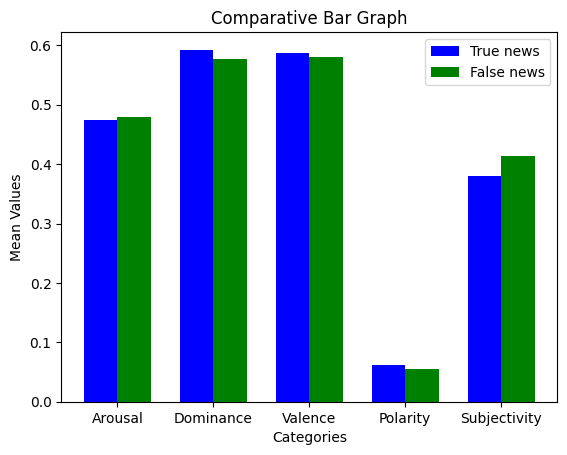

In [4]:
#plot bar graph

import numpy as np
import matplotlib.pyplot as plt

categories = ['Arousal', 'Dominance', 'Valence','Polarity','Subjectivity']

mean_group1 = avg_true[['arousal_avgLexVal', 'dominance_avgLexVal', 'valence_avgLexVal', 'polarity', 'subjectivity']]
mean_group2 = avg_false[['arousal_avgLexVal', 'dominance_avgLexVal', 'valence_avgLexVal', 'polarity', 'subjectivity']]

#create a figure and axis
fig, ax = plt.subplots()

#set the bar width
bar_width = 0.35

#positions of the left bar-boundaries
bar_l = np.arange(len(mean_group1))

#positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i + (bar_width / 2) for i in bar_l]

#create the total score bars with error bars
ax.bar(bar_l, mean_group1, width=bar_width, label='True news', color='blue')
ax.bar(bar_l + bar_width, mean_group2, width=bar_width, label='False news', color='green')
#set the x-axis ticks with names
plt.xticks(tick_pos, categories)

#set the label and title
plt.xlabel('Categories')
plt.ylabel('Mean Values')
plt.title('Comparative Bar Graph')
plt.legend()

#show the plot
plt.show()

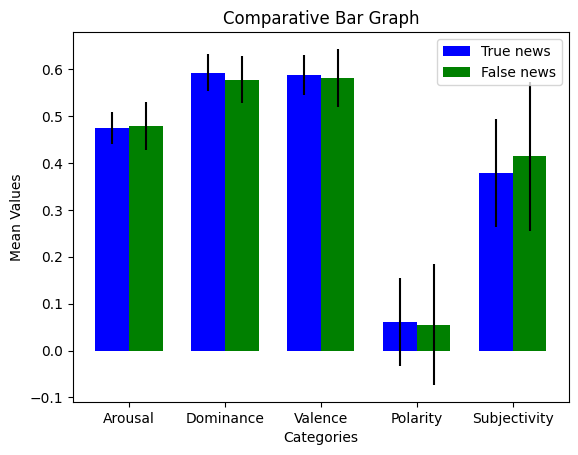

In [5]:
#plots with error bars

std_dev_group1 = np.sqrt(true_features.var()[['arousal_avgLexVal', 'dominance_avgLexVal', 'valence_avgLexVal', 'polarity', 'subjectivity']])
std_dev_group2 = np.sqrt(false_features.var()[['arousal_avgLexVal', 'dominance_avgLexVal', 'valence_avgLexVal', 'polarity', 'subjectivity']])

#create a figure and axis
fig, ax = plt.subplots()

#set the bar width
bar_width = 0.35

#positions of the left bar-boundaries
bar_l = np.arange(len(mean_group1))

#positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i + (bar_width / 2) for i in bar_l]

#create the total score bars with error bars
ax.bar(bar_l, mean_group1, width=bar_width, label='True news', color='blue', yerr=std_dev_group1)
ax.bar(bar_l + bar_width, mean_group2, width=bar_width, label='False news', color='green', yerr=std_dev_group2)

#set the x-axis ticks with names
plt.xticks(tick_pos, categories)

#set the label and title
plt.xlabel('Categories')
plt.ylabel('Mean Values')
plt.title('Comparative Bar Graph')
plt.legend()

#show the plot
plt.show()

In [6]:
#calculate standard deviation of features on true articles
std_dev_group1

arousal_avgLexVal      0.033868
dominance_avgLexVal    0.039654
valence_avgLexVal      0.042266
polarity               0.094484
subjectivity           0.115108
dtype: float64

## Statistical tests

In [7]:
!pip install -q statsmodels

import pandas as pd
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

manova = MANOVA.from_formula('arousal_avgLexVal+ dominance_avgLexVal+ +valence_avgLexVal+ polarity+ subjectivity ~ label', data=df)
print(manova.mv_test())

                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
       Intercept         Value   Num DF   Den DF     F Value    Pr > F
----------------------------------------------------------------------
          Wilks' lambda   0.0040 5.0000 77715.0000 3855570.9616 0.0000
         Pillai's trace   0.9960 5.0000 77715.0000 3855570.9616 0.0000
 Hotelling-Lawley trace 248.0584 5.0000 77715.0000 3855570.9616 0.0000
    Roy's greatest root 248.0584 5.0000 77715.0000 3855570.9616 0.0000
----------------------------------------------------------------------
                                                                      
-----------------------------------------------------------------------
           label           Value   Num DF    Den DF    F Value   Pr > F
-----------------------------------------------------------------------
            Wilks' lambda 

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


model = smf.glm(formula='label ~ arousal_avgLexVal + valence_avgLexVal + dominance_avgLexVal + subjectivity + polarity', data=df, family=sm.families.Binomial())
model_result = model.fit()

print(model_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  label   No. Observations:                77721
Model:                            GLM   Df Residuals:                    77715
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51195.
Date:                Tue, 04 Jun 2024   Deviance:                   1.0239e+05
Time:                        18:49:34   Pearson chi2:                 7.90e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05696
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4381    

In [10]:
params = model_result.params
odds_ratio = np.exp(params)
print(odds_ratio)

Intercept                  1.549699
arousal_avgLexVal          0.000064
valence_avgLexVal          0.034174
dominance_avgLexVal    66480.732947
subjectivity               0.228108
polarity                   1.606750
dtype: float64


# Further investigations with SVM

This part was realized by **Tiso E.**

**NOTE: if you have memory constraints, it is recommended that you run each section as stand-alone and then you clear the runtime. Here we provide the original dataset. Please rerun the following cell every time you disconnect the runtime.**

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from timeit import default_timer as timer

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')
path = 'drive/MyDrive/NLP/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df_topic = pd.read_csv(path+"Final_dataset.csv")

In [ ]:
df_features = pd.read_csv(path+"DatasetFeatures.csv")
df_features.drop(columns=["ratio_grammar_errors"], inplace=True)

In [ ]:
df_sentiment = pd.read_csv("/content/drive/MyDrive/NLP/dataset_sent/sentimentAnalysis.csv")

In [ ]:
common_column = 'text'

df_1 = df_topic["text"]
df_2 = df_sentiment["text"]
i = 0
miss_index = []
for j in range(len(df_1)):
  if df_1[j][:5].lower() != df_2[i][:5].lower():
    miss_index.append(j)
  else: i+=1
print(len(miss_index), miss_index[:5])

98 [1370, 1746, 1997, 3913, 4569]


In [ ]:
#realign the datasets to have the same length
df_features["topic"] = df_topic["topic"]

In [ ]:
df_features_1 = df_features.drop(miss_index)
df_features_1 = df_features_1.reset_index(drop=True)
df_sentiment_1 = df_sentiment.drop(columns=["label", "text"])

In [ ]:
#combine the datasets for the features and for sentiment analysis
df_combined = pd.concat([df_features_1, df_sentiment_1], axis=1)

In [ ]:
df = df_combined
topic_dfs = {}

#iterate through unique topics
for topic in df['topic'].unique():
  topic_df = df[df['topic'] == topic]
  topic_df = topic_df.reset_index(drop=True)
  topic_df.drop('topic', axis=1, inplace=True)
  topic_dfs[topic] = topic_df

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

#define the same SVM function as before
def apply_svm(df, label_column='label'):
    y = df[label_column]
    X = df.drop(columns=[label_column])
    print('Y shape', y.shape, "X shape", X.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report, y_test, y_pred

In [ ]:
#define the same confusion matrix function as before

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["1","0"],
        cmap=plt.cm.Blues)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    prec_score = tp / (tp + fp)
    rec_score = tp / (tp + fn)
    f1_score = tp / (tp+((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset")
    print("Precision: \t"+ str(prec_score.round(2)))
    print("Recall: \t"+ str(rec_score.round(2)))
    print("F1 score: \t"+ str(f1_score.round(2)))

Note: the following cell is an example of how the code works and its results. The same function was then applied in a loop to all the different clusters; however, it was run of a different notebook and it is very time consuming, you are able to run it but we discourage you to do so.

Topic: President Obama
Y shape (7667,) X shape (7667, 18)
Time needed: 1141s
Accuracy: 0.7750977835723598
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       663
           1       0.79      0.83      0.81       871

    accuracy                           0.78      1534
   macro avg       0.77      0.77      0.77      1534
weighted avg       0.77      0.78      0.77      1534


Precision: 	0.79
Recall: 	0.83
F1 score: 	0.81


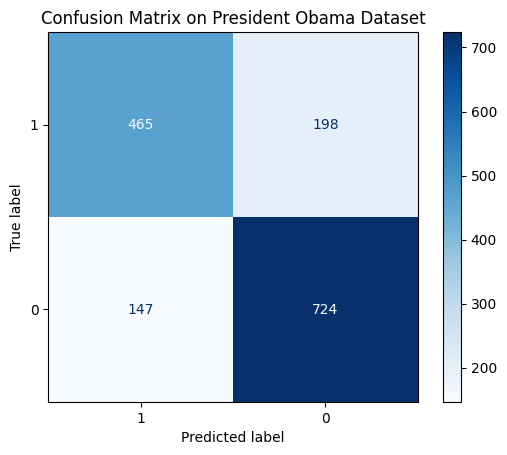

In [ ]:
print(f"Topic: President Obama")
start = timer()
accuracy, report, y_test, y_pred = apply_svm(topic_dfs["President Obama"])
end = timer()
delta = end- start
print(f"Time needed: {delta:.0f}s")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}\n")
displayConfusionMatrix(y_test, y_pred,  "President Obama")

In [ ]:
for topic_name in topic_dfs.keys():
  print(f"Topic: {topic_name}")
  start = timer()
  accuracy, report, y_test, y_pred = apply_svm(topic_dfs[topic_name])
  end = timer()
  delta = end- start
  print(f"Time needed: {delta:.0f}s")
  print(f"Accuracy: {accuracy}")
  print(f"Classification Report:\n{report}\n")
  displayConfusionMatrix(y_test, y_pred,  f"{topic_name}")